### An introduction to regression using XGBoost</center>

[XGBoost](https://xgboost.readthedocs.io/en/latest/) was the first of ***The Big Three*** [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) frameworks, released in 2014. The other two are [LightGBM](https://www.microsoft.com/en-us/research/project/lightgbm/) by Microsoft and launched in 2016, and [CatBoost](https://catboost.ai/) by Yandex, launched in 2017. Each of these frameworks are magnificent tools to tackling tabular data problems, using either regression or classification.

#### What is '*boosting*'?
First there was a **tree**. The underlying element of these technique is the decision tree. Decision trees were one of the first algorithms, dating back to the 1980s with examples such as CART, and [ID3](https://www.kaggle.com/carlmcbrideellis/titanic-using-the-iterative-dichotomiser-3-id3), C4.5 and C5.0 by Quinlan. Trees are wonderfully intuitive leading to easily interpretable results. See for example the notebook ["*Titanic: some sex, a bit of class, and a tree...*"](https://www.kaggle.com/carlmcbrideellis/titanic-some-sex-a-bit-of-class-and-a-tree). In view of this the most important hyperparameter for the [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) is the `max_depth`, although being a tree perhaps this should have really been called the maximum height...
However, despite the appealing aspects such as few hyperparameters and interpretability, the drawback of decision trees is their high variance; a slight change in the input data can lead to a radically different tree structure. A similar thing can happen if there are [collinear variables](https://en.wikipedia.org/wiki/Multicollinearity) present. Sometimes individual decision trees are know as weak predictors, or weak learners.

Then we have a **forest**. As we all know, listening to many opinions and taking an average leads to a more balanced consensus. With this in mind, why not randomly plant a lot of trees and then ensemble them into one aggregate output. Each of the trees are slightly different in that they are grown from a subset of randomly selected features, which are taken from a "bootstrapped" copy of the dataset which is made up from samples taken from the original dataset.
We now have the random forest, which outperforms the individual decision tree. Random forests are great in reducing the [variance](https://en.wikipedia.org/wiki/Variance) with respect to a single decision tree, are particularly immune to overfitting, and are wonderful for obtaining a baseline score against which to compare more extravagant techniques. For more details see the [introduction by Breiman and Cutler](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm) who invented the Random Forest in the early 2000's. With the [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) the most important hyperparameters are now `max_depth` as before, as well as `n_estimators`; which is the number of trees in the forest.

**Gradient boosting**. This time, instead of simultaneously planting a load of independent trees all at once at random (bootstrapping and aggregating aka. [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating)), each successive tree that we plant is weighted in such a way as to compensate for any weakness (residual errors) in the previous tree. This is known as [boosting](https://en.wikipedia.org/wiki/Gradient_boosting). We have the hyperparameters `max_depth`, `n_estimators` as before, and now we have a `learning_rate` hyperparameter which is between 0 and 1, and controls the amount of *shrinkage* when creating each successive new tree.

**GPU Useage:** For large and computationally intensive problems XGBoost has [GPU support](https://xgboost.readthedocs.io/en/latest/gpu/index.html) and thus can be ran on GPU's rather than on the CPU. This can be done by using the parameter

> `XGBRegressor(tree_method='gpu_hist')`


(Remember to change the kaggle notebook *Settings -> Accelerator* to `GPU`).

### <center style="background-color:Gainsboro; width:60%;">Sample script:</center>

This here is a minimalist script which applies XGBoost regression to the [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) data set. The purpose of this script is to serve as a basic starting framework which one easily can adapt. 

Some suggestions for ways to improve the score are:

* Feature engineering: creating new features out of the existing features
* Outlier removal
* Imputation of missing values: XGBoost is [resilient to missing values](https://xgboost.readthedocs.io/en/stable/faq.html), however one may like to try using the [missingpy](https://github.com/epsilon-machine/missingpy) library

**The best hyperparameters**. XGBoost has a multitude of hyperparameters, but here we shall only be using three of them. The optimal choice of these parameters can lead to a significant improvement in ones final score, so choosing the best values for these hyperparameters is important. To do this we shall perform a [cross-validated](https://scikit-learn.org/stable/modules/cross_validation.html) grid-search using the scikit-learn [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) routine. Note that this can be quite time consuming, as it tries out each and every hyperparameter combination, exhaustively checking for the best result.



In [2]:
#=========================================================================
# load up the libraries
#=========================================================================
import pandas  as pd
import numpy   as np
import xgboost as xgb

#=========================================================================
# read in the data
#=========================================================================
train_data = pd.read_csv('train.csv',index_col=0)
test_data  = pd.read_csv('test.csv',index_col=0)

### <center style="background-color:Gainsboro; width:60%;">Feature selection</center>
The purpose of feature selection, as the name suggests, is to only model the most pertinent and important features, thus reducing the computational overhead, and also to alleviate the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). The following are a number of notebooks covering techniques to achieve said goal, all of which use the House Prices data as an example:

* [Feature selection using the Boruta-SHAP package](https://www.kaggle.com/carlmcbrideellis/feature-selection-using-the-boruta-shap-package)
* [Recursive Feature Elimination (RFE) example](https://www.kaggle.com/carlmcbrideellis/recursive-feature-elimination-rfe-example)
* [House Prices: Permutation Importance example](https://www.kaggle.com/carlmcbrideellis/house-prices-permutation-importance-example)
* [Feature importance using the LASSO](https://www.kaggle.com/carlmcbrideellis/feature-importance-using-the-lasso)

However, in this notebook we shall use all of the numerical columns, and ignore the categorical features. To encode the categorical features one can use for example [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). See the excellent article ["*Ordinal and One-Hot Encodings for Categorical Data*"](https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/) by Jason Brownlee for more on the subject.

In [3]:
X_train = train_data.select_dtypes(include=['number']).copy()
X_train = X_train.drop(['SalePrice'], axis=1)
y_train = train_data["SalePrice"]
X_test  = test_data.select_dtypes(include=['number']).copy()

### Feature engineering</center>
As mentioned, one aspect of feature engineering is the creation of new features out of existing features. A simple example would be to create a new feature which is the sum of the number of bathrooms in the house:

In [4]:
for df in (X_train, X_test):
    df["n_bathrooms"] = df["BsmtFullBath"] + (df["BsmtHalfBath"]*0.5) + df["FullBath"] + (df["HalfBath"]*0.5)
    df["area_with_basement"] = df["GrLivArea"] + df["TotalBsmtSF"]

For more on this fascinating aspect may I recommend the free on-line book ["*Feature Engineering and Selection: A Practical Approach for Predictive Models*"](http://www.feat.engineering/) by Max Kuhn and Kjell Johnson.

### Now for the XGBoost estimator</center>
Note that for this competition we use the RMSLE evaluation metric, rather than the default metric, which for regression is the RMSE. For more on the peculiarities of the RMSLE see the Appendix below.

In [6]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
regressor=xgb.XGBRegressor(eval_metric='rmsle')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700}


we shall now use these values for our hyperparameters in our final calculation

In [7]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

#=========================================================================
# To use early_stopping_rounds: 
# "Validation metric needs to improve at least once in every 
# early_stopping_rounds round(s) to continue training."
#=========================================================================
# first perform a test/train split 
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
#regressor.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

#=========================================================================
# use the model to predict the prices for the test data
#=========================================================================
predictions = regressor.predict(X_test)

let us now calculate our score (for more details see my notebook ["*House Prices: How to work offline*"](https://www.kaggle.com/carlmcbrideellis/house-prices-how-to-work-offline)):

In [8]:
# read in the ground truth file
solution   = pd.read_csv('solution.csv')
y_true     = solution["SalePrice"]

from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_true, predictions) )
print("The score is %.5f" % RMSLE )

The score is 0.13722


This is certainly a big improvement over a [simple baseline using only the `OverallQual` feature](https://www.kaggle.com/carlmcbrideellis/house-prices-my-score-using-only-overallqual), which gives a score of around 0.227.

We shall now write out a `submission.csv` for the competition

In [9]:
output = pd.DataFrame({"Id":test_data.index, "SalePrice":predictions})
output.to_csv('submission.csv', index=False)

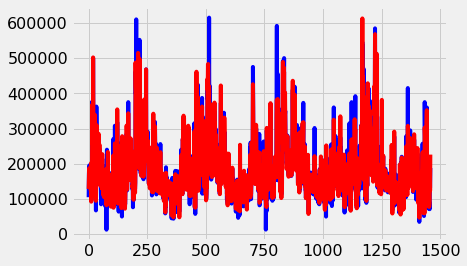

In [15]:
solution['SalePrice'].plot(color='b')
output['SalePrice'].plot(color='r')

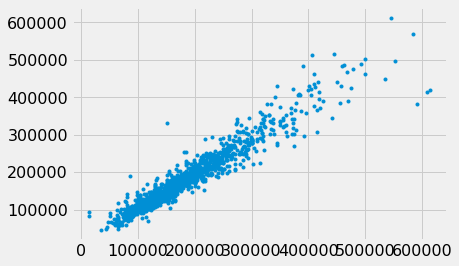

In [16]:
plt.plot(solution['SalePrice'], output['SalePrice'], '.')

### Feature importance</center>
Let us also take a very quick look at the feature importance too:

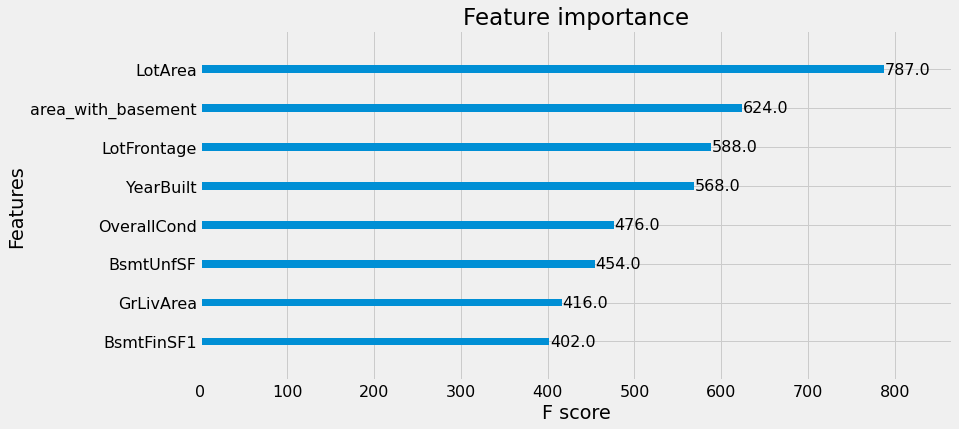

In [10]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show();

Where here the `F score` is a measure "*...based on the number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees*." [1] Note that these importances are susceptible to small changes in the training data, and it is much better to make use of ["GPU accelerated SHAP values"](https://www.kaggle.com/carlmcbrideellis/gpu-accelerated-shap-values-jane-street-example), incorporated with version 1.3 of XGBoost.
### <center style="background-color:Gainsboro; width:60%;">Links</center>
* XGBoost: [documentation](https://xgboost.readthedocs.io/en/latest/index.html), [GitHub](https://github.com/dmlc/xgboost).
* LightGBM: [documentation](https://lightgbm.readthedocs.io/en/latest/index.html), [GitHub](https://github.com/microsoft/LightGBM).
* CatBoost: [documentation](https://catboost.ai/docs/), [GitHub](http://https://github.com/catboost).

### <center style="background-color:Gainsboro; width:60%;">Videos</center>
For those who enjoy learning via videos, Josh Starmer on his YouTube channel [StatQuest](https://www.youtube.com/c/joshstarmer) has created some very accessible material:
* [Gradient Boost Part 1 (of 4): Regression Main Ideas](https://youtu.be/3CC4N4z3GJc)
* [Gradient Boost Part 2 (of 4): Regression Details](https://youtu.be/2xudPOBz-vs)
* [Gradient Boost Part 3 (of 4): Classification](https://youtu.be/jxuNLH5dXCs)
* [Gradient Boost Part 4 (of 4): Classification Details](https://youtu.be/StWY5QWMXCw)
* [XGBoost Part 1 (of 4): Regression](https://youtu.be/OtD8wVaFm6E)
* [XGBoost Part 2 (of 4): Classification](https://youtu.be/8b1JEDvenQU)
* [XGBoost Part 3 (of 4): Mathematical Details](https://youtu.be/ZVFeW798-2I)
* [XGBoost Part 4 (of 4): Crazy Cool Optimizations](https://youtu.be/oRrKeUCEbq8)

### <center style="background-color:Gainsboro; width:60%;">Related kaggle notebooks</center>
* ["GPU accelerated SHAP values with XGBoost"](https://www.kaggle.com/carlmcbrideellis/gpu-accelerated-shap-values-jane-street-example)
* ["Automatic tuning of XGBoost with XGBTune"](https://www.kaggle.com/carlmcbrideellis/automatic-tuning-of-xgboost-with-xgbtune)
* ["20 Burning XGBoost FAQs Answered to Use Like a Pro"](https://www.kaggle.com/bextuychiev/20-burning-xgboost-faqs-answered-to-use-like-a-pro) written by [BEXGBoost](https://www.kaggle.com/bextuychiev)
* ["A Guide on XGBoost hyperparameters tuning"](https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning) by [Prashant Banerjee](https://www.kaggle.com/prashant111)

### <center style="background-color:Gainsboro; width:60%;">References</center>

[1] [J. Elith, J. R. Leathwick, and T. Hastie "*A working guide to boosted regression trees*", Journal of Animal Ecology **77** pp. 802-813 (2008)](https://doi.org/10.1111/j.1365-2656.2008.01390.x)

### <center style="background-color:Gainsboro; width:60%;">Appendix: The RMSLE evaluation metric</center>
From the competition [evaluation page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) we see that the metric we are using is the root mean squared logarithmic error (RMSLE), which is given by

$$ {\mathrm {RMSLE}}\,(y, \hat y) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $$

where $\hat{y}_i$ is the predicted value of the target for instance $i$, and $y_i$
is the actual value of the target for instance $i$.

It is important to note that, unlike the RMSE, the RMSLE is asymmetric; penalizing much more the underestimated predictions than the overestimated predictions. For example, say the correct value is $y_i = 1000$, then underestimating by 600 is almost twice as bad as overestimating by 600:

In [9]:
def RSLE(y_hat,y):
    return np.sqrt((np.log1p(y_hat) - np.log1p(y))**2)

print("The RMSLE score is %.3f" % RSLE( 400,1000) )
print("The RMSLE score is %.3f" % RSLE(1600,1000) )

The RMSLE score is 0.915
The RMSLE score is 0.470


The asymmetry arises because 

$$ \log (1 + \hat{y}_i) - \log (1 + y_i) =  \log \left( \frac{1 + \hat{y}_i}{1 + y_i} \right) $$

so we are essentially looking at ratios, rather than differences such as is the case of the RMSE. We can see the form that this asymmetry takes in the following plot, again using 1000 as our ground truth value:

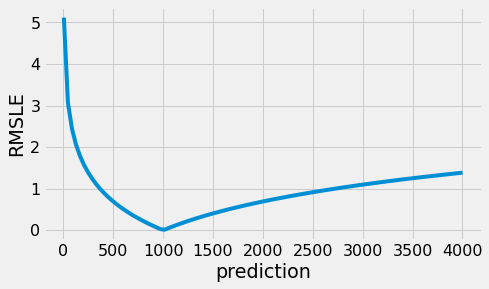

In [10]:
plt.rcParams["figure.figsize"] = (7, 4)
x = np.linspace(5,4000,100)
plt.plot(x, RSLE(x,1000))
plt.xlabel('prediction')
plt.ylabel('RMSLE')
plt.show()